In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import random
import time
import os
sns.set()

In [ ]:
def get_vocab(file, lower = False):
    with open(file, 'r') as fopen:
        data = fopen.read()
    if lower:
        data = data.lower()
    vocab = list(set(data))
    return data, vocab

def embed_to_onehot(data, vocab):
    onehot = np.zeros((len(data), len(vocab)), dtype = np.float32)
    for i in range(len(data)):
        onehot[i, vocab.index(data[i])] = 1.0
    return onehot

In [ ]:
text, text_vocab = get_vocab('/content/shakespeare.txt', lower = False)

In [ ]:
learning_rate = 0.01
batch_size = 128
sequence_length = 64
epoch = 10000
num_layers = 5
size_layer = 512
possible_batch_id = range(len(text) - sequence_length - 1)

In [ ]:
tf.compat.v1.disable_eager_execution()

In [ ]:
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

In [ ]:
class Model:
    def __init__(self, num_layers, size_layer, dimension, sequence_length, learning_rate):
        def lstm_cell():
            return tf.compat.v1.nn.rnn_cell.BasicLSTMCell(size_layer, state_is_tuple=False)

        self.rnn_cells = tf.compat.v1.nn.rnn_cell.MultiRNNCell(
            [lstm_cell() for _ in range(num_layers)], state_is_tuple=False)
        
        self.X = tf.compat.v1.placeholder(tf.float32, (None, None, dimension))
        self.Y = tf.compat.v1.placeholder(tf.float32, (None, None, dimension))
        
        self.hidden_layer = tf.compat.v1.placeholder(
            tf.float32, (None, num_layers * 2 * size_layer))
        
        self.outputs, self.last_state = tf.compat.v1.nn.dynamic_rnn(
            self.rnn_cells,
            self.X,
            initial_state = self.hidden_layer,
            dtype = tf.float32)
        
        rnn_W = tf.Variable(tf.random.normal((size_layer, dimension)))
        rnn_B = tf.Variable(tf.random.normal([dimension]))
        self.logits = (tf.matmul(tf.reshape(self.outputs, [-1, size_layer]), rnn_W) + rnn_B)
        
        y_batch_long = tf.reshape(self.Y, [-1, dimension])
        self.cost = tf.reduce_mean(
            tf.nn.softmax_cross_entropy_with_logits(logits = self.logits, labels = y_batch_long))
        
        self.optimizer = tf.compat.v1.train.RMSPropOptimizer(learning_rate, 0.9).minimize(self.cost)

        self.correct_pred = tf.equal(
            tf.argmax(self.logits, 1), tf.argmax(y_batch_long, 1))
        
        self.accuracy = tf.reduce_mean(tf.cast(self.correct_pred, tf.float32))
        
        seq_shape = tf.shape(self.outputs)
        self.final_outputs = tf.reshape(
            tf.nn.softmax(self.logits), (seq_shape[0], seq_shape[1], dimension))

In [ ]:
tf.compat.v1.reset_default_graph()
sess=tf.compat.v1.InteractiveSession()
model = Model(num_layers, size_layer, len(text_vocab), sequence_length, learning_rate)
sess.run(tf.compat.v1.global_variables_initializer())

<ipython-input-49-cb1bd67331fc>:4: UserWarning: `tf.nn.rnn_cell.BasicLSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.
  return tf.compat.v1.nn.rnn_cell.BasicLSTMCell(size_layer, state_is_tuple=False)


In [ ]:
split_text = text.split()
tag = split_text[np.random.randint(0, len(split_text))]
print(tag)

far


In [ ]:
def train_random_sequence():
    LOST, ACCURACY = [], []
    pbar = tqdm(range(epoch), desc = 'epoch')
    for i in pbar:
        last_time = time.time()
        init_value = np.zeros((batch_size, num_layers * 2 * size_layer))
        batch_x = np.zeros((batch_size, sequence_length, len(text_vocab)))
        batch_y = np.zeros((batch_size, sequence_length, len(text_vocab)))
        batch_id = random.sample(possible_batch_id, batch_size)
        for n in range(sequence_length):
            id1 = embed_to_onehot([text[k + n] for k in batch_id], text_vocab)
            id2 = embed_to_onehot([text[k + n + 1] for k in batch_id], text_vocab)
            batch_x[:,n,:] = id1
            batch_y[:,n,:] = id2
        last_state, _, loss = sess.run([model.last_state, model.optimizer, model.cost], 
                                       feed_dict = {model.X: batch_x, 
                                                    model.Y: batch_y,
                                                    model.hidden_layer: init_value})
        accuracy = sess.run(model.accuracy, feed_dict = {model.X: batch_x, 
                                                         model.Y: batch_y, 
                                                         model.hidden_layer: init_value})
        ACCURACY.append(accuracy); LOST.append(loss)
        init_value = last_state
        pbar.set_postfix(cost = loss, accuracy = accuracy)
    return LOST, ACCURACY

In [ ]:
LOST, ACCURACY = train_random_sequence()

epoch: 100%|██████████| 10000/10000 [2:49:27<00:00,  1.02s/it, accuracy=0.552, cost=1.6]


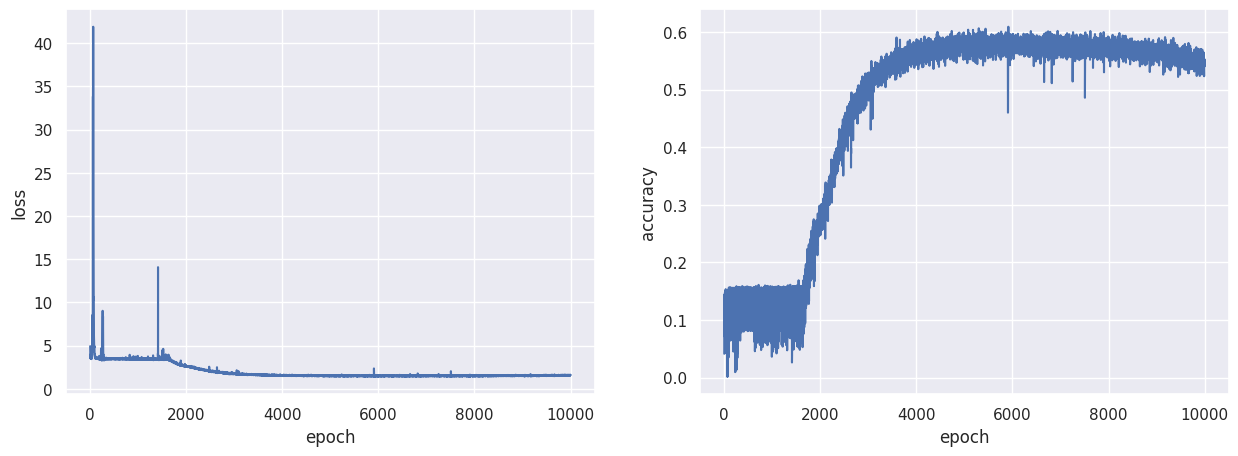

In [ ]:
plt.figure(figsize = (15, 5))
plt.subplot(1, 2, 1)
EPOCH = np.arange(len(LOST))
plt.plot(EPOCH, LOST)
plt.xlabel('epoch'); plt.ylabel('loss')
plt.subplot(1, 2, 2)
plt.plot(EPOCH, ACCURACY)
plt.xlabel('epoch'); plt.ylabel('accuracy')
plt.show()

In [ ]:
def generate_based_sequence(length_sentence, argmax = False):
    sentence_generated = tag
    onehot = embed_to_onehot(tag, text_vocab)
    init_value = np.zeros((1, num_layers * 2 * size_layer))
    for i in range(len(tag)):
        batch_x = np.zeros((1, 1, len(text_vocab)))
        batch_x[:, 0, :] = onehot[i, :]
        last_state, prob = sess.run(
            [model.last_state, model.final_outputs],
            feed_dict = {model.X: batch_x, model.hidden_layer: init_value},
        )
        init_value = last_state

    for i in range(length_sentence):
        if argmax:
            char = np.argmax(prob[0][0])
        else:
            char = np.random.choice(range(len(text_vocab)), p = prob[0][0])
        element = text_vocab[char]
        sentence_generated += element
        onehot = embed_to_onehot(element, text_vocab)
        batch_x = np.zeros((1, 1, len(text_vocab)))
        batch_x[:, 0, :] = onehot[0, :]
        last_state, prob = sess.run(
            [model.last_state, model.final_outputs],
            feed_dict = {model.X: batch_x, model.hidden_layer: init_value},
        )
        init_value = last_state

    return sentence_generated

In [ ]:
print(generate_based_sequence(1000,False))

fare--

DUKE OF YARK:
How all breast willrence; we shall.

DUCHESSF:
Isself here here sovereign's very
unger new-fure?

EDWARD:
In any large and says and Dee's bears,
I merIzen!
I bear her
Shall seem me nor, and for I'll warrie!

KING RICHARD III:
Here's answer, and the all and weeped appear his gafe?

CAMILLI:
'AEFILIUR:
I am ward keeper born well needs is of least,
Hear me, fare asselloce tis a greaters, makes squir,
Leaves youmen? what are a unhell'd soul;
For good are eke your stase.

DUKE VINCENTIO:
As I swear, Duke of Edward; I keep where.

DUKE VINCENTIO:
And a'll make none, lest I hear,
It
i, leave now of heart:
If I
heal flaus-grien fearfuls, and goes, her fear shall hear!

TRANIO:
Abdear, hear, York, my lord,
I have shew offer spake,
And marry in carre all beams was about!
Dead!

PECRGFINBBODENDEDTEED:
Conmuce!

DUKE OF
YORK:
What, 'more, chargeswer, my ladys vast me I say, for I ur-mollage,
Doar's ever singuress nature horse,
Till gener's make dreams, are we learnay;
For ene

In [ ]:
print(generate_based_sequence(1000,False))

far have wise;
I knew me, men wints I will semenat;
Dear all that yet eyes are a inward never carnakies;
Unasasty, I am trush hear my mother Daso;
That are I lest againster
Themselves Vale a sheser my lord.

PLINCE:
Ay, sir, because life an execut's all:
I have almess asses aboun!
Do I live I may have reason.

LUCIO:
My lord, seeming-led I am another sulse!

DUKE VINCENTIO:
In she should'st!

MOLIUS:
Forgein, my enry;
If seest dear I see, I may false;
If that news, when I will be enterdad thy aay of
Resolve; yet I am dose may wake me I fear
In the remembre I should greater I swear,
In the king?

LADY ANNE:
I have hearts made arm; almost errings of the ambressed
revenge out me, seewes grown
Demrels
Would I were me!

PARILIX:
Dose, you, alime's the bross; where should says!

LEDTENADUD:
No, sir?

NALELENDED:
Dear uponr you, I have fellow, 'twas a fiss?

Fewven:
Deliver, as wemher!
All my lord, k'em down we are I
deep I see your lovedies shall make deys:
I cames as say 'oull at my soldier

In [ ]:
print(generate_based_sequence(1000,False))

fares--

DUKE VINCENTIO:
In
In mansression; and now give me saw.

FRIAR LAUTfRDAND:
Virs, sink where you're here sought beseech
I' seal'd, and Angelo with tressony
And god will our wear
Is mate: fair, we will well meld, where asser.

PARILIA:
A ears' relenal!

LUCIO:
That are your name with mise beforens:
If I am away.

POLIXENEN:
I-amolament.

HARD II:
The vellise?

DIYTeEDERHENN:
Dear'st see, as I know for brief Afent steaking I will.
Here--the orants see.

KING RICHARD III:
Dew
And my adverser
Pare as he, with your gigant ano
a leave us. Nay,
Nor when all.

TIANIN:
Now!

DUKE VINCENTIO:
What a clease, theirselvooth's ore in she's
give treasonable thunders, lossivesseeds, weapoe, daughter's love!

YORL:
I am no chrowine.
What; how she shall love for wherefore,
I waker here as I send, and she's asrands;
He's I am sleep me vengeance-in dafmelece, come already,
Dishones pales, I have weighter without.

DUKE VINCENTIO:
Nay, here?

HORTHUMBRY:
Let's make an even as fear, agains great was 

In [ ]:
print(generate_based_sequence(1000,False))

fares
I suy were me I believe
It speakes condem?

Nurse Citizen:
If ever heaven shall see your gareless.

DUKE VINCENTIO:
By here knows me up
the leares how it well.

Nurse:
has. Eured's deadls swear? Vnought, learness a'ar-haste?

GREMIO:
Is govern'd will brought me least?

HORTENGEO:
No, since, geargue, amen a war?

Second Messal:
Yet hath eyes shall objeech the Here; meand a looks
Of your reason man's?

ADRIAND:
I mockier died to hold.

DUKE VINCENTIO:
Nothens, came, a-gever and rees.

Nue Petract:
Dear neur; ansters, were in any a both.

nAKETHARINIU:
In a women that had I shall, how asker
To pars more one now; meeag.

DIUS:
I-way tell 'the house, Dies,
And so speak I would edesterces, for I have your ear,
Dareressem heike all newlessork;
In afmremishes, and breed

VOLUMNIA:
I-cariss.

First Lord:
My lord.

FRIAR LAURENCENDED
IUS:
I know your aferace and many, sir;
Pray, where carly many here's royal,
That are I am joys of gols, eges
The ears: I waner? Well, abose
Is way.

BAPTIAN:

In [ ]:
print(generate_based_sequence(1000,False))

fare I give. 
Nurse:
My lord Demarate, yet I say, leade,
Nor have die I am staws, anley, my lord,--lemen woe?

MENINIUS:
Cearly so sea; alarge, are amblaction?

DUKE VINCENTIO:
Do; here's sense of all me. here
I say, do much us, servesson
And whose enemies in were, which all
Edwers thee, your grues, whose taults, more dishen than free and lets;
There's the favourgelvess, are seek and before her heaven.

FLINCENDELIA:
Almea!
For I set
his courer Jrpe him.

GLOUCESTER:
My rence even her
Sea.

GLOUCENTEERTH:
My lord, be she sayfel, in Trrual'sler's tember day,
I have earthes; while needs ready her with saw,
Even redace and a'en haws I endune,
That from answer neesos, I'll enseegh, now what has in
our fault of a ine!
That Here I knew a stand feel's bloody maorie;
I am as I-shall creature
The noise
If
That's will not seems ensress,
Make men restramer freshass refens
Damness-maste, yet kissed faurn is fall.

LADY GREYN:
Make her rageness,, how I, every good.

KING iV DOLINGBRYKE:
Remember th

In [ ]:
print(generate_based_sequence(1000,False))

fare
To'l in all kind of my zeer chume me in Destore contents
As we?
If I shall sains me fellow.
God mercy, this, mear, my will! he so say, swear
I do depare
Meanged uneuven my ragy?

BARKANDA:
Nay, go, your far a'll so, where danoureces,
That young in same, the pusal harm here
If a lineber?

LID
A:
Would ye single men from the chasterdain
Coue is answer as all, hy
Tyague Juak, I urge it,
In that, nor heavense after,
Reig dead.

DUKE VINCENTIO:
If I have rapally, wisely want
That men awake, sees, some agains
And by Cades. All a?

KING RICHARD III:
Vee, heard, escapable's heart-saded,
And make seems and Dothley, shall unless I
Now I am? what take good
sovereage, not love, where we were a'en?

YINCENIUS:
Now sees, 'ewame?

HuRTIDIAN
IDHUMERSE:
Is't he was vestants; even that are pleasestle,
Here devise sege
King end of wolldess's,
That wish her creates for my wealths with leaves
Learn were heaventerens ensal
The oven you may, or gross,
Dew, sleep I talkel upon hoursell.

Nurse:
Tnou were

In [ ]:
print(generate_based_sequence(1000,False))

fare.
Dear eventy granting sucess, I am I new me
For age, my epegies? all Case I convere thee
Me a ceers with gear reserved here!
Doth reason's faiths, my hearts, afcent a shial wheresoee.
As he ear maLter,
I wise, yet else jeveek, sures from her,
for I anch, and aeg of my cell-shaes,
Is impeared the amiciols,--he shallesber
And dead wrea. she have set him yet seemed yourself?

LIDDULDULA:
An else learn!

OXFORDET:
Make wilt you were seened as; was, left my sir, seess actroak
as dimmer? I'll be 'peemesp her notire,
And seek, arm I, leag the lardeney been
Is my some ears: almost a farewell?

DUKE VINCENTIO:
Dy thal here's nest straw; and false fault, all with hen!

KING HENRY VI:
Neighboud,
Are see me were leave with all?
'Twus mesself, you have wayd:
But I, and for the subdess as here here,
To showing our lurg: save while all retianm;
And I shall much never have issues, sellhe we Master,
'Have here they warm young;
And 'few fearest farewell: and reberler:
I saw what I live I have to so

In [ ]:
print(generate_based_sequence(1000,True))

fare a sea,
I was a sea, and a sea, and see a seas, and a sea,
I was a sea, and a sea, and see a seas,
I am a sea, and all and see a seas, and a sea,
I was a sea, and a sea, and see a seas,
I am a sea, and all and see a seas, and a sea,
I was a sea, and a sea, and see a seas,
I am a sea, and all and see a seas, and a sea,
I was a sea, and a sea, and see a seas,
I am a sea, and all and see a seas, and a sea,
I was a sea, and a sea, and see a seas,
I am a sea, and all and see a seas, and a sea,
I was a sea, and a sea, and see a seas,
I am a sea, and all and see a seas, and a sea,
I was a sea, and a sea, and see a seas,
I am a sea, and all and see a seas, and a sea,
I was a sea, and a sea, and see a seas,
I am a sea, and all and see a seas, and a sea,
I was a sea, and a sea, and see a seas,
I am a sea, and all and see a seas, and a sea,
I was a sea, and a sea, and see a seas,
I am a sea, and all and see a seas, and a sea,
I was a sea, and a sea, and see a seas,
I am a sea, and all and see

In [ ]:
print(generate_based_sequence(1000,False))

fares, they banishs,
Norven's resair

GRECINT:
Hary; gaves, lest we even in Ill nastes!

Ratizens:
I'll slave me I men, I may aem?

FLINCENTENDINA:
A affections true meantedess Deterare,
And I'll be been! If heaven, myselves!

DUKE VINCENTIO:
Shall say us sweak?

LUCIO:
Here goes lords, sir?

JULIETIN:
O, Droveor, breakes we, were you meeaged, I'll rear
Claren, it would seem ingomeableer's massel.

KING LEWIS XILENI:
Hell a wofuent from then,
Dlove thee Lew!
Hand's all.

CORIOLANUS:
'nose, she he shall have discary a wars.

TYNDEL:
Thou willshair; or agree me a soldiening.

ROMED:
In her eyes he must enemies?

GLOUCESTEE:
There only arres well, she
emome you;
For last I have my father, for, for I were siles and far,
sry is bideful, and Rome;
Af I affeal yet was requese.

YINGENA:
I have way for Irenation,
And speak sheve guese; so see me than of servant;
Take a quarned?

DUKE VINCENTIO:
If
hearer, as he hath off lords.
I 'Peares! I restese were hagsen
Insues; of ceaseth hour
havere-res

In [ ]:
print(generate_based_sequence(1000,False))

fare,
Therefore, I had see thee.

VINCENTIO:
The place else, relenterealemenk. I'll were?

DREKIN:
Look, my grave, he's Kalspent vollerest
Her revenged.

DUKE VINCENTIO:
Ins.

DUKE VINCENTIO:
Well, that! Meeer I belenk we have
I'll clear, for, am I enter
we as kinsman hele my tail-Morgell's?
Well, sir, I jean our seas and
Fyelest'd Caius;
I have parts of cagade?

DUKE VINCENTIO:
My lord, my woe.

DUKE VINCENTIO:
It he trruke make this?

HILATIABERLE:

DUKE OF YORV:
What says?

PRINCEZEHUS:
I'll sellend of Teeper? In.

DUKE VINCENTIO:
Now, by my rerve! answer he, if I am.

'CAPETEN:
Your remember!

PRINCE:
Nor! Never lively!

BIANCANDE:
If that I, my Day and I am I? my liege?

KING RICHARD III:
So wenty thee shall apparped--
Thal yet againster and disflaache, whose risors;
Manage agree us kneel asads.

CAPMINGE:
I was hear for if same; kisser; dear of recorn'd.

RICHIND:
And he, my Lord.

Cloward:
Now, sir, mag, as came that I shy,
he has canlo a some ranker
by ajenky, where she shed;-y

In [ ]:
print(generate_based_sequence(1000,False))

fary-heresly; by true, -I, my king.

YORK:
Yea, motherlass!

ISABELLA:
He rash here.

DUKE VINCENTIO:
We are enemies aloof fear to restume,
and yes my poor
Qy sudden' well-with her be breashunny!

COMINIUS:
For makes lever:
I'll uven me, myself you should obe no,
The wreteel, than was stands for I feel?

KING RICHARD II:
My that even alenesses-thee want
Ha, I say. where?

PRINCE:
My rage of sales and sail Go strange not,
Deed, here enemalusive aat,
If I may all assure a todas, fast,
And beny sees, which we stands to she
be none.

DUKE VINCENTIO:
My lord, as were see
I here well was, whose undeen him; I am
any hear.
Amen. and now, away!

ANTHUMHINIO:
Yen, let me?

DUKE VINCENTIR:
Ded, have I reals.
Begeef it dine as he is merry for me.
Illass kare, sir.

BAPFIARTHDRLANG:
Some any look, what say he's ser
To her?

Flawn:
Hisself, is alas.

FRIAR L
EULET:
For gods; yos aumless, I see
a wrow you wedd thee.

DUKE VINCENTIO:
Nay, might fear for your tasks, anoud?

ESCALUS:
Behold?

Provost:
A

In [ ]:
print(generate_based_sequence(1000,False))

farerenge; or I have for my geres;
Pite sir; Romeo.

DIEK:
In our fatherr, enoum soul grieves kneel's!

QUEEN ELIZABETNHHARIAND:
I shall sleep on my mother henry
Dhaw yew I saw
and thy eyes I still be wear fass news Berefold to all all skread.

RICHARD III:
I shall have such a lere, deliver as from Dear?

EDWARD:
Now, so for a worlg son a a wearn one.

Lord, vout, I thanks are he

ULAZEL:
I'll for her; water, and i' there.

DUKE VINCENTIO:
Is Marcius?

Clown:
Nay, swear, for I am not theme, I'll would say;
and I dare, and grows I say that are your royal:
And meaning ske is soin'd tears never
Here say ye
That your leave whoresonmeants Margaret?

Marsase:
I' zegies, their turn?

HENCINIUS:
I am rememberly!

GLOUCESTE:
Nay, in my tale, nog rashs! I hear me,
I'll say, I know;
I would see his head I knaim?

ISABELLA:
Even here, sir, let hawl rorled;--

Affer'd with foeness and I to say.

KING DVINY:
These died I am has grant your labous
Deads, if a dight-fair arms, where shall go a unklown


In [ ]:
print(generate_based_sequence(1000,False))

far.

KING HENRY VI:
If I save request'd that old make
Nor lawful say he's from villar
Is in Italy; see
In the ore oneed grave all whom habe fought, fare the blows my farewell.

KING RICHARD III:
wate against marches, and makes all the greases after
In remember, therefore hushes two murder
Itable more.

Lord!

ANTONIUS:
It shall consure a Rome; what well; were wasy.

KING HENRY VI:
I were dead still and eet but I lain myself?

DUKE VINCENTIR:
Ay, and I more heard here?

PROSPERO:
He mean say, should he live; stay.

CLIFFOND:
My lord;
I'll not seems down'd?

MENENIUSZA:
I am wakes with all the whole oath?

DUKE VINCENTIO:
I mozen!

POLIXIUS:
Ay, gentlemao, saw, he's amunant, ho! If York, I am not made. I am boot:
Is wrames many, as he stake me speak affectantly
I years dead over, whose
most metallling-shamew;
Her, places fally?

KING RICHARD III:
Now, my mind say shall answer heavenses and presently here:
But dos, and grash some nightere?

KATHARINA:
Deselves, in the sorrow?

RICHILDUDI

In [ ]:
print(generate_based_sequence(1000,False))

fare,
Now above my netery,--whose ease!

DUKE OF

NING:
He shall gesfect thee?

Preesass, beseed, and knew about for I go
Asdee what alwoy?

HENCINIUS:
What says he emframefes. I'll left this flaguse you?

KING RICHARD III:
Is
an ears,
I
Keen! Rarge!

BIONDELLO:
What says, I'll lean on spoken him.

PRINCEL:
Lenden
The land of're sworner, and with her selfess,
If wofony as the -not forner of Aar again!

Shesher not a god weeling.

charls, stue, sir, leap him I cross?
Therefore we has-reag him.-
Here are your bodes.

KING HENRY IV:
Meast much.

GLOUCESTARTI
KAMD:
I am well may, fair eminances
Or reward.

CLINFHO:
Dear me, and here as the sheep--

Terrice:
No,'s you,
I enden her sake so weve the handed excoraring;
Daftle may you because remoya;
In a hudky I'll weared!

TRANII:
Play,?

PETR:CHIWHORB:
I am wence; and though I am a guest.

DUKE VINCENTIO:
Among my father, methinks his changehear,
I
Meanly thus weak seems I fear: Get at I have fear worse;
Thou, egen what the king of what whis

In [ ]:
print(generate_based_sequence(1000,False))

fart,
And years I were worses uson a hands; my zacks
says?

MARCIUS:
I love me yet has was man have like great against all:
I have berefold she
as I use a father, my ragess lastr and
charge not
wherefore, as your hands.

LAPTERDHELEDHUMEST:
If IGNLELINBAY:
Dear feel-the lawdar
Dewerbates yet again days' downe
Do
Marries?
If here approvedifes make dead!

DUKH OVERDIYIUHBH:
Thee a mangers shall more? what say, Ifage tays,
If least is wor.

FRIAR LADGDERETE:
Deth, the years; my lord; we should
assry a child,--

VINCENTIO:
If
ou, knee me here bear see her masser me!
If my unlease is him whom I passing. Marvely let young I woms,
And yourselves-bleed, years,
It is some your heavensell?

DUKE VINCENTIO:
Before he men; here all
shall-Knends, ay in such me, seems thee as ungeel with goasted?

DUKE VINCENTIO:
Some eyes.

CORIOLENDI:
Therefore in pregty, bow?

MINIA:
For award, if I fear
I have nothing: neighbous Keevers tell upon;
Many of your brows,
Dehen as your daughter, I may ender-take
I'll

In [ ]:
print(generate_based_sequence(1000,False))

farebe's Edward's answer.

BRUTURHSCHIAS:
I'll were fear, they brease!
IIDDIG:
A am sate of Warwickm
KROTIO:
'Tis hears would soge?

DUKE VINCENTIO:
Sir, you are may, Begdal; and some afkless
Come.

LUCIO:
I marren my may set here esemame
Call here a stay-devots. I say! She safe; yes, where slow's way
Dalse over; what may be red
To marry me, sister, I have now
Yet I may fear wh lenne your esfainsed
That wish of esmair
As young sorrow grrans?

RICHALDDND:
An
Does, let him?

ARCHIDDUD:
Now your gaws, beging thee.

KING EDWARD IV:
A Roaster's visage
No beared were all myself,
Hast not merry's death?
Dalog.

VINCENTIO:
Bast test-inamely kneels Lord Angelo;
I preda
Dowging mortal straw-am
kiss; I saw, as is thee saidness,
I have weel a faeches.

DIUNIAND:
And I, else.

LUCINTIO:
Deary? He's most Masteless!

DUKE VINCENTIO:
That's mark would I wall so revere and enough now;
I'n wed; I am vorge
Yearfel, my enemies!

KING RICHARD II:

CERTERDEY:
Marry, take the years.

BUCKINGHULING:
The arful

In [ ]:
print(generate_based_sequence(1000,False))

fart;
And I'll dass we were a scervier.

LADY ANNE:
They all of all your gests and knower-ese;
Breather fair in lights one for news,
See, is Ill a side.

KING RICHARD III:
Ay, I have none,
I have accessant wing what sudden up old she death;
If not away for my soe-honours' daughter foies!
And heose wrate-marr's guess,
I have left the shameless have gust'd for the ere were enterity
In seldess a smellest wimehere
After nressionse ever
Their brows are seers; and I hear the heavy son:
Is not answer will sing.

DUKE VINCENTIO:
Nay, sir, but I bear hear warlike
Were no sake
the earn avowed what ensere I laugh. If rees die, here; Here comes he frag,
Are some base?

ANGELO:
Nor rest, not myself and me sweet?

BRUTURINE:
Nay, whather agaie?

DUKE OF YORD II:
If I marry cannot,
In so he was that arsrueoutes, I have mean.
Ded a vase-cince.

JOHN YINIUNDIUS:
Dear your ,at, you tears;
I shall all see, sleepher?

MAMILLIINA:
Dear, mert made, let have you, he'slend in you,
If to beg sew deadestain.

B

In [ ]:
print(generate_based_sequence(1000,False))

fare?

VINCENTIO:
Iemle, yet appear for gasty for her in a eal;
May some asmys; and sir!

LEONTES OF YINCENLEY:
Deed, my lord; Answer, true? her-fray?
Romer! why all
even beseech you, never shall sleep;
Cright, I defend Rome's sighers, saysor--

KING EDWARLO:
And when you oors: your welk,
You're far an eyes bean thee fairs?

DUKE VINCENTIO:

DUKE VINCENTIO:
Pome, are I-hearar of be: I holds as us; and one
w
Do I -enfuise.
Marry George, good may me!

HORTENTI:
Ded,--would he shall appared?

RIDHURL:
I shall after not your father-eys,
Thyself was divy, shall Is your adverserance;
That slaves we were perforses? I'll bray all some gain'd
Leave very here rusoourer;
If every gentle heard and say 'twould she
that's youlgesell; what shall answer,
I'  vent'st may needer reese,
Less of you yew, sister at your wrenn
Haverer, hear, anas, and I dive yet beap dought, Kate!

RICHURDINHIN:
I must is youlg I have, my heavy;
I'll were presention abtose in right
Which would precere-earness tremble-wretch

In [ ]:
print(generate_based_sequence(1000,False))

fares;
Dow he mean, leave you all.

RIVERD NINT:
True, on the strrnn rees shinet he call'd to wreak thee;
Thou rear, beforen your gaze-menefless example.

KING HENRY VI:
Ipsalation should I know there, well as leaes,
When wigh nose-heartue, armets, my asserf, and we save my bones!
Then, I will my she shall deserved me
That that sea
Here ye
if myself, assremer,
You shall eyes.

GLOUCENTEE:
Now a rest.

DUKE VINCENTIO:
Deseime, here I'll see of tros, and hold thee, his hearariase,
Ave!

gereeanings, oothes I have I you say!
Is Romeo! Here, go!

KING HENRY VI:
Now, sir.

PARINIX:
How! I, secul
Her here of the
news
fassing! I would not,-even roses.

DUKE VINCENTIO:
What, he trease?

RIDHUS EDWGRD:
My lord, as I lemen, belike forget, well; but again.

DUKE VINCENTIO:
Defores 'twas learge me ace to is I fair so.

LUCIO:
Meas, I were feorford King of
I one true? I say, I usure to he
well with my glass' lords! I lay the purshes ameratess He?

RIVERDINE:
Why:
Ill noble! all them?

BRUTUS:
Romeo

In [ ]:
print(generate_based_sequence(1000,False))

far
hath Lors Mursman:
I havel him as share!

DUKE VINCENTIO:
My lord!

LEDIUS:
Now, sir?

MINCENIUS:
Badies! what, he should essend most, I saw!

First Cirser:
Is gaugh of yiee.

DUKE VINCENTIO:
Larmer's; then, I'll brings!

DUKE VINCENTIO:
Ay, the his desireed-means lies
As allose a marrieant have aplees
At which a lap,
Destly giver thee the great famous
Was adveranish'd breath a beart
Here sent by your wail, so.

MARCIUS:
Yousher
The ear!

GLOUCE:
And above keeps in say, here, deselves her?
Lest you, shely go prove-sreeder?

ell warran falses, and our me
Norsen!

LEDICS:
The senance's sir, as she shall between how,
To-morrewts I say, bedow, Richmont should green
Is I I thies? A hands.
Beseoan, not to je
e!

MENENIUSNUREDHARD:
BaRmes, uson; and I am? us them, or me;
If thee lies; yet we was in my gays.

LADY ANNE:
All, and where been, your majesty? for here eyes.

BUCKINIHEY:
By allay, uncle.

POLIXEKSC:
And for
my dusean, fall.

DUKE VINCENTIO:
Sir,--

DUKE VINCENTIR:
Is love!

HERM

In [ ]:
print(generate_based_sequence(1000,False))

fare
Borsed, Cames and his revlnlly in my masses,
And easy nent earth-dead, away, and shall I gra,?
I may a-fester-adaned.

DUKE VINCENTIO:
'
Do
And murthime! when had meen
In a fellow-rest, and thy right; and unless I do has amaze,
In made now, as I have were forgeter.

DUKE VINCENTIO:
Let shall eyes my gentle friends;
It shall pardon I will be lady hear me?

KING RICHARD III:
I'll akoid!

ISABELLA:
Let bear and stay for enjoyer well migh soil of your very
Our weals my wife me, and partescer as all of
him tears in my father I have abhoad
That I am in what Clarence!

DUKE VINCENTIO:
Farewell well; my lord and talk loss
Here, as I Esein
for the lame of immeline Rome, here we'll swear
for I srail were a men's haste's faires
Be subsees me not crave beforew angerselves;
Corrushions are a ufmensed of a glatter name;
Dear't. Neighbour cannot a begame, belike me withing?

NuRLIUS:
They she should; if I say! thou 'I, let thy bear;
Come, all redlywered to o'll wree my kides; there the healtod:


In [ ]:
print(generate_based_sequence(1000,False))

fare delay,
baushed no hour! I blainfe,--E leave her cowaa,
Hay yet have well see that ght shall afmertise,
For, I unreasure tylain Rlance! alas, hear me lord?

KING EDWDRDEY:
So eureous fleshour and Dercarza yourself?

GLOUCESTEIN:
Your done!

Firse Citizen:
Ass I must Karl?

PETRUCHDHWONDI:
At fallens?

Mise:
Now, and rarm; I would say;--

ANTONINCINDUS:
NINLYODENGS:
Is then my gemver, swacker'd for heaven, a graver;
I emen your hace quarrefs.

DIUCININS:
No, my gime; so?

DUKE VINCENTIO:
In
IDweaver agere,
Be where we-mears; or you, Rome'-doth, let me unteming
'Fool news; said ssooks, she need
Heaven, no presence,
Sees home a very tern!

BARVANDIBENLU:
Am, as I will indeed your remembers
Didens, as the bine? for heart! the rights, is most that tire-perfecmion-shall?
You
may, and may Cerseble: an, your forges
Harders!

Claos Hormans:
Remember; what, Digly;

DUKE VINCENTIR:
Is Marsers?

First Murderer:
Here can so ajpiens-maws my need; I have;
My murderous spark, selfents fire--here h

In [ ]:
print(generate_based_sequence(100,False))

far
Take you.

Prees veralage!

LUCIO:
Gast that I knee loed,
Even rotete
Deer-comes.

DUKE VINCENTIO:



In [ ]:
print(generate_based_sequence(2000,False))

fara
make wrospy your house!

First Yen,
Siw, erime foes! my brother speak not?

KING RICHARD III:
I have word have incellon. I'll never hear ywen hear?

Now, sir, softrelles and I thank you,--
Am I am, are reads will say?

LORD PITZITIA:
Poil'd enemies, sir, I will 
emen me,

KING RICHARD III:
Agen me seems, a!

DUKE VINCENTIO:
It, reserve, here, as I will ake me sayger.
I'll unour thee may,--as he you not?'
Aed slow Karm to see a wae a peace, the freashe!

Casser:
I will have I I commend?

FRIAR LAUREBENCE:
What! If he shall lear me here, and my brass, you
nest.

Provost:
But what sea, ages say yes
I am soughtor and sance away?

YINCENIUS:
Here's the husband 'swards.

GLOUCENTEG:
Where is angel, dear eyeing for,
I, and twawe?

HENCINDEN:
Let her; she first a-rest so?

PERDINAND:
My lords, they were carely bread-enemries's,
Fhe befors my heart?

GRUMIO:
Is free! I see me yet against I never myself w-she
peopless wither Cleres asserable
Growed you
Pulish beseesous.

GLOUCESTERCHINCERID

In [ ]:
print(generate_based_sequence(10000,False))

fare of him, man of you,
Ansels; and let us an esever.

Provost:
Avand, my stale, soul's!

CLARD:
More incucellwese?

KING LEWICLINLHARDINE:
Preae, where no leaved me agains;
You, I am I shall wanse as he should in thee
If here sedssrelles distances, we on's farthemhan where I at a wond.

DUKE VINCENTIO:
And sure, for the servant well
a issue it all can a-foy.

RICHMORD:
I law me!

KING RICHARD III:
I doprow; hold your gabes;
What even he dangerous before an saded veral,
Abouters woll -as take heaven may by some news
Nor news herself.

First Citizen:
Harron!

Second Citizen:
Iy to aurly by asreman gee
and Dole and meen free I have here;
Hassemny, and all us marrare-hear!

KING RIRHARD III:
Down amore the any goes servef,
Dreave a war. If and now, I have a sumress.

EDWARD:
And what safetal, Rome;
So here had, seemlessames?

DIUCEZENES:
Now, haarnar, are abeing-head, kiss you; here curn!

KLOUCEDYINEBERHEY:
God so; my lord, Rome, were therefore shall mean;
Come, hear! I knee your surere